# Function to fit our analytical model to the SF-gas from TNG

This fit procedure is also described in section 3 of [van Son et al. 2023](https://ui.adsabs.harvard.edu/abs/2022arXiv220903385V/abstract).



In [1]:
import sys
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from scipy import interpolate
from scipy.optimize import minimize
from scipy import optimize as opt

# from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck15  as cosmo# Planck 2015 since that's what TNG uses
from astropy.cosmology import z_at_value

############################
# Custom scripts
sys.path.append('../')
import get_ZdepSFRD as Z_SFRD
import importlib
import paths

import ReadFitData as read
importlib.reload(read)

#Change file names to match TNG version
Cosmol_sim_location = paths.data / "SFRMetallicityFromGasTNG50-1.hdf5"
fit_filename = 'test_best_fit_parameters_TNG50.txt'
rbox = 35 #35 for 50, 75 for 100, 205 for 300

# First read the data that you want to fit to
***
We will have simulation data == TNG in our case
Make sure to convert it to a SFDR in Msun/yr/Mpc^-3

model data  == our analytical function

## Make sure you provide at least:

- Sim_SFRD = SFRD(z,Z)/($\Delta$Z), in $\rm{M}_{\odot} \rm{Mpc}^{-3}$
- MetalBins, in metallicity $Z$
- Lookbacktimes, in $\rm{Gyr}$

It is important that you provide the SFRD per dZ bin!! Otherwise your fit will be bin dependent, which is not what you want.. 



In [2]:

########################################
# Low Z extreme from Chruslinska 2021
#'204'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat', 
# Sim_SFRD, Lookbacktimes, Sim_center_Zbin, dFOH = read.load_martyna_data(file_name = '214'+ 'f14SB'+'BiC'+ '_FMR270'+ '_FOH_z_dM.dat', 
#                                                                         data_dir = str(paths.data)+'/SFRD_Z_z_data/')
# fit_filename = 'MartynaLOWZ_best_fit_parameters.txt'

# #########################################
# # high Z extreme from Chruslinska 2021
# Sim_SFRD, Lookbacktimes, Sim_center_Zbin, dFOH = read.load_martyna_data(file_name = '302'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat',
#                                                                         data_dir = str(paths.data)+'/SFRD_Z_z_data/')
# fit_filename = 'MartynaHIGHZ_best_fit_parameters.txt'

#########################################
# TNG 100 data
# rbox=75 for TNG100, 35 for TNG50, and 205 for TNG300
Sim_SFRD, Lookbacktimes, Sim_center_Zbin, step_fit_logZ, Redshifts = read.load_TNG(loc = Cosmol_sim_location, rbox=rbox)


### Now we're going to make some cuts 

Because the minimum metallicity in COMPAS is 10^-4, there is no use in fitting to the 10^-7 metallicity tail.

This cuts out the "POP-III" star formation that is happening at 10^-7 in the cosmological simulation. Since we don't capture this kind of stellar evolution in the pop-synth, we don't want to skew our distribution to try and capture that


In [3]:
minZ_popSynth    =  1e-6
## Adjust what metallicities to include 
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   

## Reverse the time axis of the SFRD and lookback time for the fit
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 

## Convert lookback times to redshifts
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_Sim = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
redshifts_Sim.append(0) # put redshift zero back at the end
redshifts_Sim = np.array(redshifts_Sim)


## Interpolate the fit data

To ensure that we have a nice and smooth set to compare to 

Using scipy interpolate
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

f = interpolate.interp2d(x, y, z)



In [4]:
#########################################
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

#########################################
# Retrieve values at higher res regular intervals
redshift_new         = np.arange(0, 10.1, 0.05)
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500)

SFRDnew = f_interp(Lookbacktimes_new,metals_new)


    

In [5]:
##################################################
# muz =-0.09, mu0 =0.026, sigma =1.9, alpha=-3.3
##################################################
def calc_chi_square(fit_metals, Redshifts = [],  simulation_SFRD = [],
                    mu_0  = 0.026, muz  =-0.09, sigma0  = 1.9, sigmaz  = 1.9, alpha =-3.3,
                    sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2):
    """
    Calculate the squared residual of your simulation_SFRD vs your analytical model.
    Args:
        fit_metals        --> [float]          metals used for fit
        Redshifts         --> [float]          redshifts used to fit
        simulation_SFRD   --> [float]          cosmological simulation data to fit to
        
        # metallicity distribution parameters (skew-log-normal)
        mu_0              --> [float]          location (mean in normal) at redshift 0
        muz               --> [float]          redshift evolution of the location
        sigma0            --> [float]          Scale at redshift 0 (variance in normal)
        sigmaz            --> [float]          redshift evolution of Scale (variance in normal)
        alpha             --> [float]          shape (skewness, alpha = 0 retrieves normal dist)
        # overall SFR parameters
        sf_a              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_b              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_c              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_d              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)

    Returns:
        tot_chi_square    --> [float ] 

    """ 
    #####################################
    # Get the SFR (Shape of Madau & Fragos 2014)
    sfr = Z_SFRD.Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d).value # Msun year-1 Mpc-3 
    # Get dPdZ (skew-log-normal distribution)
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(Redshifts,mu_z = muz , mu_0 = mu_0 ,
                                                  omega_0= sigma0 , omega_z=sigmaz , alpha = alpha , 
                                                  metals=fit_metals)
    
    ######################################
    data           = simulation_SFRD                # Model comes in dP/dlogZ, so should your sim-data !
    model          = sfr[:,np.newaxis] * dPdlogZ 

    # The square of the residuals
    res_squared = ((data - model )**2)
    #divide by N elements to get Mean Squared Error
    #N_elements  = len(res_squared.flatten()) 
    #mean_squared_err = res_squared/N_elements
    
    # Divide over the sum of the model at each redshift,
    # reduces contribution from high sfr redshifts & increases the weight where sfr is low
    chi_square = res_squared/np.sum(model, axis = 1)[:,np.newaxis]
    
    # Return sum Chi_squared and the max squared residual
    return np.sum(chi_square), data, model 


    
    

# Run your chi square calculations

## and leave the refinement up to scipy minimize

In [6]:
#################################################################
## Function wrapper to minimize the Chi_square
#################################################################
def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2] ):
    chi_square, data, model = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                       muz  =x0[0], mu_0  =x0[1],sigma0  =x0[2], sigmaz =x0[3], alpha  =x0[4],
                                       sf_a =x0[5], sf_b=x0[6], sf_c=x0[7], sf_d=x0[8])
    #print(chi_square)
    return chi_square

# BEST GUESS
x0     = np.array([-0.15, 0.026, 1.1, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2])
#        # mu_z        # mu_0     # omega_0 #omega_z  #alpha       #sf_a       #sf_b       #sf_c       #sf_d
bounds = ((-1., 0), (0.001, 0.1), (0.01, 5), (0, 1.), (-10, 0), (None,None),(None,None),(None,None),(None,None))
# FIT
res = minimize(test_chi, x0= x0, method = 'BFGS',# other options include: 'nelder-mead', L-BFGS-B
               options = {'gtol': 0.05})

# Alternative: res = opt.basinhopping(test_chi, x0= x0, minimizer_kwargs={'method':'BFGS'})


In [7]:
with h5.File(paths.data / "SFRMetallicityFromGasTNG100-1.hdf5", "r") as f:
        MetalBins100     = f["MetalBins"][:]
        Lookbacktimes100 = f["Lookbacktimes"][:]
        BoxSfr100      = f["Sfr"][:]
        Redshifts100     = f["Redshifts"][:]

In [8]:
with h5.File(Cosmol_sim_location, "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
        Redshifts     = f["Redshifts"][:]

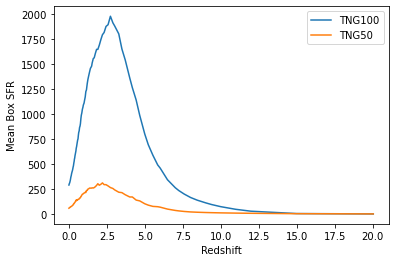

In [9]:
plt.plot(Redshifts100, np.mean(BoxSfr100, axis=1), label='TNG100')
plt.plot(Redshifts, np.mean(BoxSfr, axis=1), label='TNG50')
plt.xlabel("Redshift")
plt.ylabel("Mean Box SFR")
plt.legend();

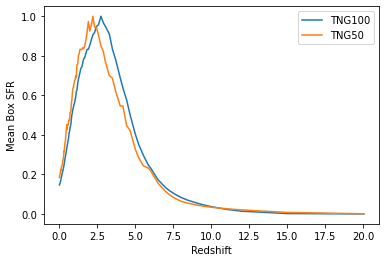

In [10]:
#normalized to 1
plt.plot(Redshifts100, np.mean(BoxSfr100, axis=1)/max(np.mean(BoxSfr100, axis=1)), label='TNG100')
plt.plot(Redshifts, np.mean(BoxSfr, axis=1)/max(np.mean(BoxSfr, axis=1)), label='TNG50')
plt.xlabel("Redshift")
plt.ylabel("Mean Box SFR")
plt.legend();

In [11]:
print(res.success, res.message, 'N iterations: ', res.nit)
muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best = res.x[0], res.x[1], res.x[2], res.x[3],res.x[4]
sf_a_best, sf_b_best, sf_c_best, sf_d_best               = res.x[5], res.x[6], res.x[7], res.x[8] 

print('\nBEST FITTING PARAMETERS:')
print('mu0 =%s, muz =%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (mu0_best, muz_best, sigma0_best, sigmaz_best, alpha_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )

chi_square, data, model = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                   muz =muz_best, mu_0 =mu0_best,sigma0 =sigma0_best, sigmaz=sigmaz_best,alpha=alpha_best,
                                   sf_a =sf_a_best, sf_b=sf_b_best, sf_c=sf_c_best, sf_d=sf_d_best)
print('chi_square',chi_square, 'max_res_squared', np.amax( (data-model)**2) )

# Calculate standard error on params
from numpy.linalg import inv
N_elements  = len(data.flatten()) 
v = res['fun']/   N_elements  # variance of residuals, sse/n
var = v*inv(res['hess_inv'])
se = np.sqrt(np.diag(var))
print('standard error', se)
# for i, val in enumerate(res['x']):
#     print(np.round(val,3), ' pm ',  np.round(se[i],4) )

True Optimization terminated successfully. N iterations:  32

BEST FITTING PARAMETERS:
mu0 =0.0263442343838559, muz =-0.022780838215113015, sigma_0 =1.0525731260860975, sigma_z =0.06686405502987136, alpha=-1.6693671251232172
sf_a =0.031141230156074718, sf_b =1.5494490648788826, sf_c =3.748417636595504, sf_d =4.988996892748576
chi_square 0.04528253582288159 max_res_squared 0.00010494347397432077
standard error [0.00672146 0.04615788 0.00165713 0.01445601 0.00041789 0.05160383
 0.00207976 0.00117513 0.00044937]


In [12]:
if res.success:
    np.savetxt(paths.data / fit_filename,
               np.c_[mu0_best, muz_best, sigma0_best, sigmaz_best, alpha_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best],
               header = "mu0, muz, omega0, omegaz, alpha0,sf_a, sf_b, sf_c, sf_d", delimiter=',', fmt="%s")


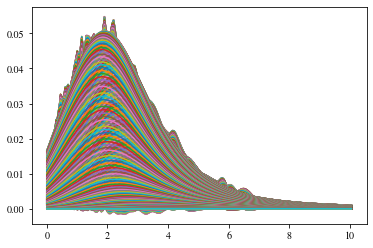

In [49]:
# Get the SFR (Shape of Madau & Fragos 2014)
sfr = Z_SFRD.Madau_Dickinson2014(redshift_new, a=sf_a_best, b=sf_b_best, c=sf_c_best, d=sf_d_best).value # Msun year-1 Mpc-3 
# Get dPdZ (skew-log-normal distribution)
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshift_new ,mu_z = muz_best , mu_0 = mu0_best ,
                                                  omega_0= sigma0_best , omega_z=sigmaz_best , alpha = alpha_best , 
                                                  metals=metals_new)
    

model = sfr[:,np.newaxis] * dPdlogZ
plt.plot(redshift_new, SFRDnew.T); #simulation
plt.plot(redshift_new, model); #fitted model, best fit
Rboxval = 35 #35 for TNG50, 75 for 100, 205 for 300

## Check my new fits for TNG100

In [13]:
new_vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG100.txt", skiprows=1, delimiter=",")
old_vals = np.loadtxt(paths.data / "test_best_fit_parameters.txt", skiprows=1, delimiter=",")
ticks =  ["mu0", "muz", "omega0", "omegaz", "alpha0","sf_a", "sf_b", "sf_c", "sf_d"]

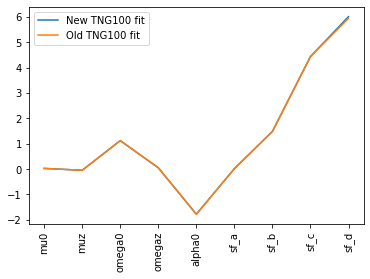

In [14]:
fig, ax = plt.subplots(1,1) 
x = [0,1,2,3,4,5,6,7,8]
ax.plot(x, new_vals, label='New TNG100 fit')
ax.plot(x, old_vals, label="Old TNG100 fit")
ax.set_xticks(x)
ax.set_xticklabels(ticks, rotation='vertical', fontsize=10)
ax.legend();

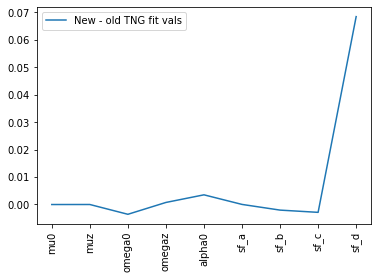

In [15]:
fig, ax = plt.subplots(1,1) 
x = [0,1,2,3,4,5,6,7,8]
ax.plot(x, new_vals-old_vals, label='New - old TNG fit vals')
ax.set_xticks(x)
ax.set_xticklabels(ticks, rotation='vertical', fontsize=10)
ax.legend();

## Compare fit parameters across TNGs

In [16]:
tng100vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG100.txt", skiprows=1, delimiter=",")
tng50vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG50.txt", skiprows=1, delimiter=",")
ticks =  ["mu0", "muz", "omega0", "omegaz", "alpha0","sf_a", "sf_b", "sf_c", "sf_d"]

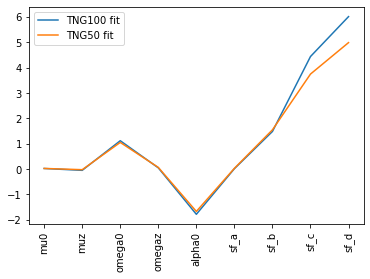

In [17]:
fig, ax = plt.subplots(1,1) 
x = [0,1,2,3,4,5,6,7,8]
ax.plot(x, tng100vals, label='TNG100 fit')
ax.plot(x, tng50vals, label="TNG50 fit")
ax.set_xticks(x)
ax.set_xticklabels(ticks, rotation='vertical', fontsize=10)
ax.legend();

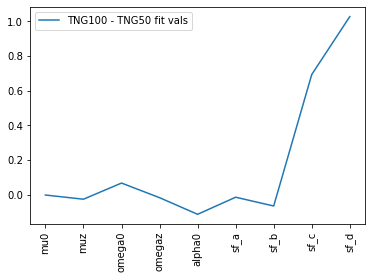

In [18]:
fig, ax = plt.subplots(1,1) 
x = [0,1,2,3,4,5,6,7,8]
ax.plot(x, tng100vals-tng50vals, label='TNG100 - TNG50 fit vals')
ax.set_xticks(x)
ax.set_xticklabels(ticks, rotation='vertical', fontsize=10)
ax.legend();

# Visualize the fit

Let's try to visualize how well our fit matches the simulation, by plotting the **squared residuals**:

\begin{equation}
\log_{10} \lvert \mathcal{S}(Z_i, z_j)_{sim} - \mathcal{S}(Z_i, z_j)_{fit} \rvert
\end{equation}


And the relative error


\begin{equation}
\log_{10} \frac{\lvert \mathcal{S}(Z_i, z_j)_{sim} - \mathcal{S}(Z_i, z_j)_{fit} \rvert}{\mathcal{S}(Z_i, z_j)_{fit}}
\end{equation}



(202, 500)
(202,) (500,)
[-7. -6. -5. -4. -3. -2.]


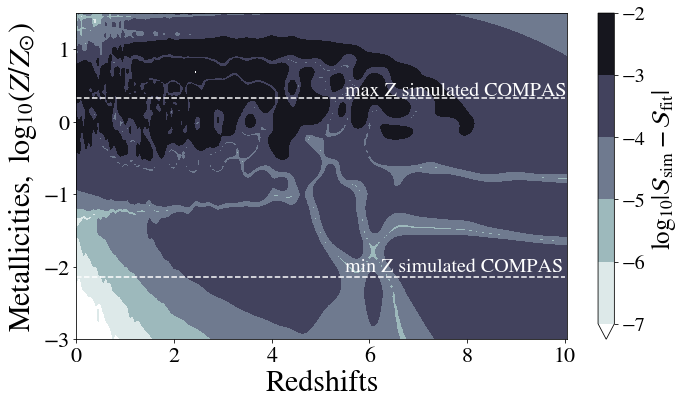

In [19]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

res_squared = (data - model)**2
print(np.shape(res_squared))
print(np.shape(redshift_new),np.shape(metals_new))
Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-7, -2, num=6)
print(levs)
cs = plt.contourf(X, Y, np.log10( abs(data-model).T), 
                  levs, cmap ="bone_r",extend ='min')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} | \mathcal{S}_{\rm sim} -\mathcal{S}_{\rm fit}| $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)


# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5.5, np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'white' )
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'white', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5.5, np.log10(0.032/Zsun)), fontsize = 20, color = 'white' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'white', linestyle = '--')

######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.savefig(paths.figures / 'log_res.pdf',  bbox_inches='tight')
plt.show()


-5.834490937942307 14.075244764287826
[-3. -2. -1.  0.  1.  2.  3.]


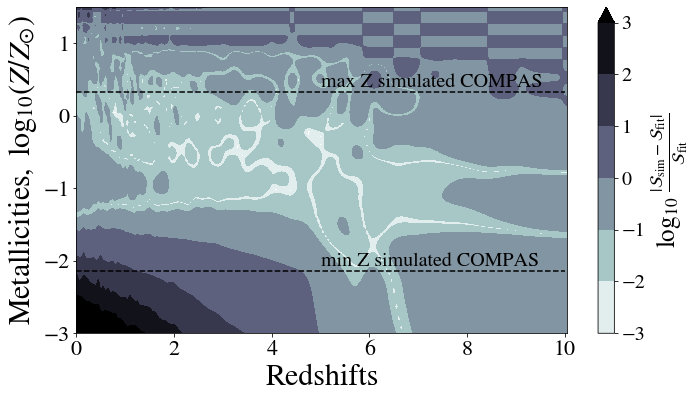

In [20]:
############################
abs_relative_err = abs(data-model)/model
Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-3, 3, num=7)
print(np.amin(np.log10(abs_relative_err)), np.amax(np.log10(abs_relative_err))) 
print(levs)
cs = plt.contourf(X, Y, np.log10((abs_relative_err).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \frac{| \mathcal{S}_{\rm sim} - \mathcal{S}_{\rm fit} | }{\mathcal{S}_{\rm fit}} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.savefig(paths.figures / 'log_relative_err.pdf',  bbox_inches='tight')
plt.show()


[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_91625/2846804007.py:20: RuntimeWarning: divide by zero encountered in log10
  cs = plt.contourf(X, Y, np.log10((Sim_SFRD).T),


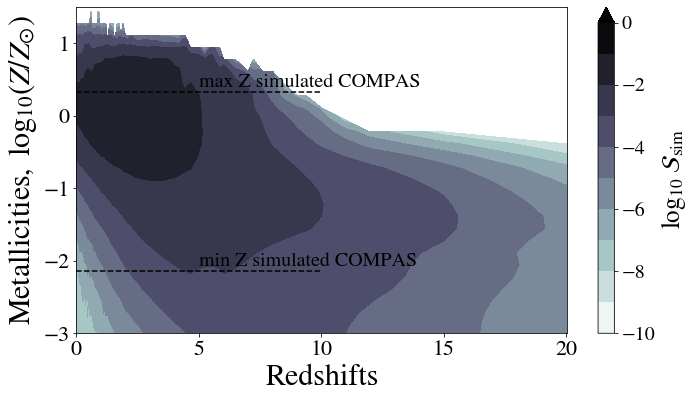

In [21]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(Redshifts,  np.log10(Sim_center_Zbin/Zsun))

levs = np.linspace(-10, 0, num=11)
print(levs)
cs = plt.contourf(X, Y, np.log10((Sim_SFRD).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \mathcal{S}_{\rm sim} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.show()


[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


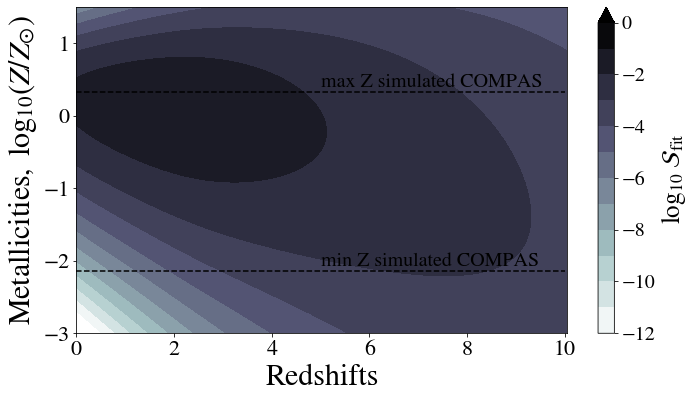

In [22]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-12, 0, num=13)
print(levs)
cs = plt.contourf(X, Y, np.log10((model).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \mathcal{S}_{\rm fit} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.show()
